# <center> Crash Course on Variational Monte Carlo </center>
<center> Lecture 3: AD and Neural Networks</center>

<h3><center>Filippo Vicentini</center></h3>

<center>filippo.vicentini@epfl.ch</center>


<center>https://github.com/PhilipVinc/vmc-crash-course-2010</center>



EPFL, 22 October 2020

In [5]:
# Some imports®
import jax
import numpy as np
from jax import numpy as jnp
from matplotlib import pyplot as plt

# <center>Jastrow Wavefunction</center>

The jastrow ansatz for the wavefunction is:
$$
\psi_{W}(\sigma_1, \dots, \sigma_N) = \exp[\sum_{i,j} \sigma_i W_{i,j} \sigma_j] = \exp[\sigma^T W \sigma]
$$

We actually want to encode the 
$$
\log\psi_{W}(\sigma_1, \dots, \sigma_N) = \sigma^T W \sigma
$$


## Using NetKet 
The devil is still in the python

In [6]:
# Importing netket (that ain't too hard)
import netket as nk

In [7]:
# How many spins we want in our model
N = 8 

# Define a 1D lattice (or graph) for our model
graph = nk.graph.Grid([N], pbc=True)

# Define the Hilbert space
ℋ = nk.hilbert.Spin(graph, s=0.5)

In [81]:
Ĥ = nk.operator.Ising(h=2.0, hilbert=ℋ)

## Defining Neural Networks in Jax

A simple example: The RBM (Restricted Boltzmann Machine):
$$
 \psi(\sigma) = \sum_{j=1}^{\alpha N} \mathcal{G}\left(\sum_{i=1}^N W_i^j \sigma_j + b_i\right)
$$
But i prefer to write it like:
$$
    \psi(\sigma) = \left[\Sigma \circ \mathcal{G} \circ D\right] (\sigma)
$$

### The dense layer (also known as affine layer)
The dense layer is an affine transformation:
$$
 \vec{D} (\sigma) = W \vec\sigma +  \vec{b}   
$$

note: Sometimes, the element-wise activation function is included in the dense layer (but we do not)

In [82]:
import jax

In [83]:
# Stax is an (experimental) submodule with neural-network related stuff
from jax.experimental import stax

In [84]:
α = 2 # We define the hidden layer density
dense = stax.Dense(α * ℋ.size) # As we have shown last time, this is actually a tuple of functions...
dense_init, dense_apply = dense

In [85]:
dense_out_shape, dense_weights = dense_init(jax.random.PRNGKey(0), (-1, ℋ.size))
print("The dense layer output shape is:", dense_out_shape)
print("The dense layer weights has type:", type(dense_weights), "of length ", len(dense_weights))
print("\t dense_weights[0] = ", type(dense_weights[0]), ", shape =", dense_weights[0].shape, ", dtype=", dense_weights[0].dtype)
print("\t dense_weights[1] = ", type(dense_weights[1]), ", shape =", dense_weights[1].shape, "  , dtype=", dense_weights[1].dtype)

The dense layer output shape is: (-1, 16)
The dense layer weights has type: <class 'tuple'> of length  2
	 dense_weights[0] =  <class 'jax.interpreters.xla.DeviceArray'> , shape = (8, 16) , dtype= float32
	 dense_weights[1] =  <class 'jax.interpreters.xla.DeviceArray'> , shape = (16,)   , dtype= float32


### The activation function
We chose logcosh: 

$$ 
    \mathcal{G}\circ \vec{x} = log\circ cosh \circ \vec{x} 
$$
    
This is always applied elementwise

In [86]:
# We define our activation function
def logcosh(x):
    # log(cosh(x)) but smarter
    x = x * jnp.sign(x.real)
    return x + jnp.log(1.0 + jnp.exp(-2.0 * x)) - jnp.log(2.0)

In [87]:
# We define the layer applying the activation function element-wise
LogCoshLayer = stax.elementwise(logcosh)

In [88]:
ew_shape, ew_weights = LogCoshLayer[0](jax.random.PRNGKey(0), dense_out_shape)
print("The elementwise layer output shape is:", ew_shape)
print("The elementwise layer weights has type:", type(ew_weights), "of length ", len(ew_weights))

The elementwise layer output shape is: (-1, 16)
The elementwise layer weights has type: <class 'tuple'> of length  0


### The reduction layer
We take as reduction the sum of all the inputs $x\in\mathbb{R}^M$:

$$
\Sigma \circ \vec{x} = \sum_i^{M} x_i
$$

In [89]:
# The reduction layer
def SumLayer():
    def init_fun(rng, input_shape):
        output_shape = (-1, 1)
        return output_shape, ()

    def apply_fun(params, inputs, **kwargs):
        return inputs.sum(axis=-1)

    return init_fun, apply_fun

### Chaining the functions together
$$
    \psi = \left[\Sigma \circ \mathcal{G} \circ D\right]
$$

Known as a serial layer or chain

In [90]:
#And we can put everything together by chaining everything with a serial (or chain) object:
neural_net = stax.serial(stax.Dense(α * ℋ.size), stax.elementwise(logcosh), SumLayer())

In [91]:
# Wrap it in a netket machine object, associating the hilbert space
ψ = nk.machine.Jax(ℋ, neural_net, dtype=float)

## Intermezzo: About PyTrees
Jax, PyTorch, Flux, and basically ANY modern ML framework store parameters in a ~~Py~~Tree.

A ~~Py~~Tree tree structure of containers, ordered or unordered, recursively nested, which might or might not hold some leaf nodes. 
Data is only stored in leaf nodes, which are usually N-d arrays or similar structures holding state.

In [92]:
print("ψ has ", len(ψ.parameters), "sets of parameters, 1 per layer:")
print("\t 1. has length:", len(ψ.parameters[0]), "with shapes:", 
          ψ.parameters[0][0].shape, "and ", ψ.parameters[0][1].shape)
print("\t 2. has length:", len(ψ.parameters[1]))
print("\t 3. has length:", len(ψ.parameters[2]))

ψ has  3 sets of parameters, 1 per layer:
	 1. has length: 2 with shapes: (8, 16) and  (16,)
	 2. has length: 0
	 3. has length: 0


Transformations you can do on trees:

  - Apply a function to all leaf nodes, return the transformed tree:

In [93]:
jax.tree_map(lambda x: print(x.shape),  ψ.parameters);

(8, 16)
(16,)


  - Flatten the tree into an ordered list of leaf-nodes, and additional data used to reconstruct the tree from the flattened data

In [94]:
flat_pars, tree_structure = jax.tree_flatten(ψ.parameters)
print("flat_pars has is a", type(flat_pars), "with", len(flat_pars), "leaf-nodes inside:")
for (i, el) in enumerate(flat_pars):
    print("\t the", i,"- th element is a", type(el), "of dtype", el.dtype, "and shape", el.shape)
print("tree_structure is a:", type(tree_structure))

flat_pars has is a <class 'list'> with 2 leaf-nodes inside:
	 the 0 - th element is a <class 'jax.interpreters.xla.DeviceArray'> of dtype float32 and shape (8, 16)
	 the 1 - th element is a <class 'jax.interpreters.xla.DeviceArray'> of dtype float32 and shape (16,)
tree_structure is a: <class 'jaxlib.xla_extension.PyTreeDef'>


  - Reconstruct the PyTree from the flattened data

In [95]:
new_tree = jax.tree_unflatten(tree_structure, flat_pars)
print("new_tree has ", len(new_tree), "sets of parameters:")
print("\t 1. has length:", len(ψ.parameters[0]), "with shapes:", 
          ψ.parameters[0][0].shape, "and ", ψ.parameters[0][1].shape)
print("\t 2. has length:", len(ψ.parameters[1]))
print("\t 3. has length:", len(ψ.parameters[2]))

new_tree has  3 sets of parameters:
	 1. has length: 2 with shapes: (8, 16) and  (16,)
	 2. has length: 0
	 3. has length: 0


## Back To all our ingredients to optimise the energy...

In [96]:
# The machine:
ψ = nk.machine.Jax(ℋ, neural_net, dtype=float)

# Local sampler (we saw it the previous lecture)
sampler = nk.sampler.MetropolisLocal(ψ, n_chains=16, sweep_size=N)

In [97]:
def sample(sampler, n_samples):
    sampler.reset()
    sampler.generate_samples(n_samples//10)
    σs = sampler.generate_samples(n_samples)
    return σs

In [178]:
from netket.operator import local_values
def estimate_observable(Ô, ψ, σ_samples):
    
    # Flatten the batch and chain dimensions
    N = σ_samples.shape[-1]
    σ_samples_r = σ_samples.reshape((-1, N))

    # Compute the  Oᴸᵒᶜ(σ)
    loc = local_values(Ô, ψ, σ_samples_r).reshape(σ_samples.shape[0:2])
    
    return loc, nk.stats.statistics(loc.T)

In [180]:
σs = sample(sampler, 500)
elocs, stat = estimate_observable(Ĥ, ψ, σs)
print("<H> = ", stat)

<H> =  -11.966+0.000j ± 0.039 [σ²=12.126, R̂=1.0001]


### The gradient of the local energy
Recall:
$$
    F_k = \langle \hat{E}^\text{Loc} \hat{O}_k \rangle -  \langle\hat{E}^\text{Loc}\rangle \langle\hat{O}_k \rangle = \langle \Delta\hat{E}^\text{Loc} \Delta\hat{O}_k \rangle
$$

where 
$$
\Delta\hat{O} =\Delta\hat{O} - \langle \Delta\hat{O} \rangle 
$$

In [181]:
def estimate_gradient(σ_samples, ψ, Eloc):
    # Center the Local energies: Eᴸᵒᶜ = Eᴸᵒᶜ - ⟨Eᴸᵒᶜ⟩ 
    Eloc -= nk.stats.mean(Eloc)
    
    # Flatten the batch dimension
    N = σ_samples.shape[-1]
    σ_samples_r = σ_samples.reshape((-1, N))
    n_samples_tot = σ_samples_r.shape[0]
    Eloc_r = Eloc.reshape(-1, 1)
    
    # Compute the propagation of the 
    grads = ψ.vector_jacobian_prod(σ_samples_r, Eloc_r / n_samples_tot)

    # if real parameters but complex gradient, take only real part
    if not ψ.has_complex_parameters:
        return nk.vmc_common.tree_map(lambda x: x.real, grads)
    else:
        return grads

## Iterative optimisation according to gradient descent..

In [183]:
# So to perform one step of optimisation...
n_samples = 2000
F = estimate_gradient(σs, ψ, elocs)

In [194]:
# Build the optimiser
op = nk.optimizer.jax.Sgd(ψ, learning_rate=0.05)

In [195]:
# Generate the new parameters
new_params = op.update(F, ψ.parameters)

# Replace the old parameters with the new
ψ.parameters = new_params

## The training loop

In [217]:
## This cell is here so that I don't have to go back up if I try to change the network...

N = 8

# Define a 1D lattice (or graph) for our model
graph = nk.graph.Grid([N], pbc=True)

# Define the Hilbert space
ℋ = nk.hilbert.Spin(graph, s=0.5)

neural_net = stax.serial(stax.Dense(2 * ℋ.size), stax.elementwise(logcosh), SumLayer())

ψ = nk.machine.Jax(ℋ, neural_net, dtype=float)

# Local sampler (we saw it the previous lecture)
sampler = nk.sampler.MetropolisLocal(ψ, n_chains=16, sweep_size=N)

# The ham
Ĥ = nk.operator.Ising(h=0.6, hilbert=ℋ)

op = nk.optimizer.jax.Sgd(ψ, learning_rate=0.05)

In [218]:
Evals = []
for i in range(100):
    σs = sample(sampler, 500)
    elocs, stat = estimate_observable(Ĥ, ψ, σs)
    
    F = estimate_gradient(σs, ψ, elocs)
    ψ.parameters = op.update(F, ψ.parameters)
    
    Evals.append(stat)

In [219]:
# Exact solution
sol = nk.exact.lanczos_ed(Ĥ)
E0 = sol.eigenvalues

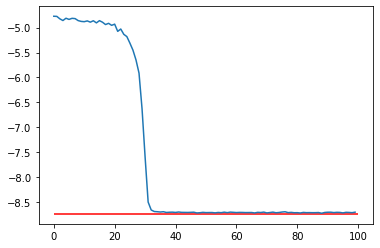

In [222]:
plt.plot([e.mean for e in Evals])
#plt.plot([e.mean for e in Evals2])
plt.hlines([E0], xmin=0, xmax=len(Evals), colors=['red'])